In [2]:
import pandas as pd
import numpy as np
import xml.etree.ElementTree as xet
from glob import glob
import matplotlib.pyplot as plt

In [3]:
!kaggle datasets download -d alihassanml/car-number-plate

Dataset URL: https://www.kaggle.com/datasets/alihassanml/car-number-plate
License(s): apache-2.0
 46% 18.0M/39.1M [00:01<00:01, 15.9MB/s]
100% 39.1M/39.1M [00:01<00:00, 36.5MB/s]


In [4]:
import zipfile
file = zipfile.ZipFile('/content/car-number-plate.zip')
file.extractall('data/')
file.close()

In [5]:
path = glob('/content/data/images/*.xml')
path

['/content/data/images/N88.xml',
 '/content/data/images/N160.xml',
 '/content/data/images/N231.xml',
 '/content/data/images/N95.xml',
 '/content/data/images/N124.xml',
 '/content/data/images/N186.xml',
 '/content/data/images/N34.xml',
 '/content/data/images/N143.xml',
 '/content/data/images/N238.xml',
 '/content/data/images/N46.xml',
 '/content/data/images/N92.xml',
 '/content/data/images/N179.xml',
 '/content/data/images/N175.xml',
 '/content/data/images/N113.xml',
 '/content/data/images/N219.xml',
 '/content/data/images/N206.xml',
 '/content/data/images/N195.xml',
 '/content/data/images/N149.xml',
 '/content/data/images/N200.xml',
 '/content/data/images/N145.xml',
 '/content/data/images/N163.xml',
 '/content/data/images/N78.xml',
 '/content/data/images/N187.xml',
 '/content/data/images/N116.xml',
 '/content/data/images/N43.xml',
 '/content/data/images/N176.xml',
 '/content/data/images/N244.xml',
 '/content/data/images/N61.xml',
 '/content/data/images/N69.xml',
 '/content/data/images/

In [6]:
labels_dict = dict(filepath=[],xmin=[],xmax=[],ymin=[],ymax=[])
for filename in path:
    # file_name = path[0]
    info = xet.parse(filename)
    root = info.getroot()
    member_object = root.find('object')
    label_info = member_object.find('bndbox')
    xmin = int(label_info.find('xmin').text)
    xmax = int(label_info.find('xmax').text)
    ymin = int(label_info.find('ymin').text)
    ymax = int(label_info.find('ymax').text)
    # print(xmin, xmax, ymin, ymax
    labels_dict['filepath'].append(filename)
    labels_dict['xmin'].append(xmin)
    labels_dict['xmax'].append(xmax)
    labels_dict['ymin'].append(ymin)
    labels_dict['ymax'].append(ymax)

In [7]:
df = pd.DataFrame(labels_dict)
df.head()

,filepath,xmin,xmax,ymin,ymax
0,/content/data/images/N88.xml,208,370,89,173
1,/content/data/images/N160.xml,153,251,196,217
2,/content/data/images/N231.xml,581,700,273,319
3,/content/data/images/N95.xml,23,408,173,391
4,/content/data/images/N124.xml,165,328,276,324


In [8]:
import os
def getfilename(filename):
    file_name = xet.parse(filename).getroot().find('filename').text
    file_image = os.path.join('/content/data/images',file_name)
    return file_image

In [9]:
image_path = list(df['filepath'].apply(lambda x:getfilename(x)))
image_path

['/content/data/images/N88.jpeg',
 '/content/data/images/N160.jpeg',
 '/content/data/images/N231.jpeg',
 '/content/data/images/N95.jpeg',
 '/content/data/images/N124.jpeg',
 '/content/data/images/N186.jpeg',
 '/content/data/images/N34.jpeg',
 '/content/data/images/N143.jpeg',
 '/content/data/images/N238.jpeg',
 '/content/data/images/N46.jpeg',
 '/content/data/images/N92.jpeg',
 '/content/data/images/N179.jpeg',
 '/content/data/images/N175.jpeg',
 '/content/data/images/N113.jpeg',
 '/content/data/images/N219.jpeg',
 '/content/data/images/N206.jpeg',
 '/content/data/images/N195.jpeg',
 '/content/data/images/N149.jpeg',
 '/content/data/images/N200.jpeg',
 '/content/data/images/N145.jpeg',
 '/content/data/images/N163.jpeg',
 '/content/data/images/N78.jpeg',
 '/content/data/images/N187.jpeg',
 '/content/data/images/N116.jpeg',
 '/content/data/images/N43.jpeg',
 '/content/data/images/N176.jpeg',
 '/content/data/images/N244.jpeg',
 '/content/data/images/N61.jpeg',
 '/content/data/images/N69.j

In [10]:
# Data Processing

In [11]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import load_img,img_to_array

In [12]:
label = df.iloc[:,1:].values

In [13]:
import cv2
data = []
output = []
for i in range(len(image_path)):
    image = image_path[i]
    image_read = cv2.imread(image)
    h,w,d = image_read.shape

    # Preprocessing
    load_image = load_img(image,target_size=(224,224))
    load_image_arr = img_to_array(load_image)
    normalize_image = load_image_arr /255.0

    # Normalize Label
    xmin,xmax,ymin,ymax  = label[i]
    nxmin,nxmax = xmin/w,xmax/w
    nymin,nymax = ymin/h,ymax/h
    labelNorm = (nxmin,nxmax,nymin,nymax)
    #------------append
    data.append(normalize_image)
    output.append(labelNorm)

In [14]:
X = np.array(data,dtype=np.float32)
y = np.array(output,dtype=np.float32)

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)

In [16]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((180, 224, 224, 3), (45, 224, 224, 3), (180, 4), (45, 4))

In [17]:
from tensorflow.keras.applications import MobileNetV2,InceptionV3,InceptionResNetV2
from tensorflow.keras.layers import Dense,Flatten,Dropout,Input
from tensorflow.keras.models import Model
import tensorflow as tf

In [18]:
inception_resnet = InceptionResNetV2(weights="imagenet",include_top=False,
                                     input_tensor=Input(shape=(224,224,3)))
inception_resnet.trainable=False
# ---------------------
headmodel = inception_resnet.output
headmodel = Flatten()(headmodel)
headmodel = Dense(500,activation="relu")(headmodel)
headmodel = Dense(250,activation="relu")(headmodel)
headmodel = Dense(4,activation='sigmoid')(headmodel)
# ---------- model
model = Model(inputs=inception_resnet.input,outputs=headmodel)

219055592/219055592 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [19]:
# complie model
model.compile(loss='mse',optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4))
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 111, 111, 32)   │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 111, 111, 32)   │             96 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 111, 111, 32)   │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 109, 109, 32)   │          9,216 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 109, 109, 32)   │             96 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 109, 109, 32)   │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 109, 109, 64)   │         18,432 │ activation_1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 109, 109, 64)   │            192 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 109, 109, 64)   │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 54, 54, 64)     │              0 │ activation_2[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 54, 54, 80)     │          5,120 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 54, 54, 80)     │            240 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activation) │ (None, 54, 54, 80)     │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 52, 52, 192)    │        138,240 │ activation_3[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4     │ (None, 52, 52, 192)    │            576 │ conv2d_4[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_4 (Activat

 Total params: 73,663,490 (281.00 MB)

 Trainable params: 19,326,754 (73.73 MB)

 Non-trainable params: 54,336,736 (207.28 MB)

In [20]:
history = model.fit(x=X_train,y=y_train,batch_size=10,epochs=100,
                    validation_data=(X_test,y_test))

Epoch 1/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 63s 2s/step - loss: 0.1556 - val_loss: 0.2181
Epoch 2/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 39s 83ms/step - loss: 0.1561 - val_loss: 0.1133
Epoch 3/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - loss: 0.1119 - val_loss: 0.1248
Epoch 4/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 80ms/step - loss: 0.1156 - val_loss: 0.1173
Epoch 5/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 0.1182 - val_loss: 0.1146
Epoch 6/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 115ms/step - loss: 0.1151 - val_loss: 0.1148
Epoch 7/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 85ms/step - loss: 0.1132 - val_loss: 0.1119
Epoch 8/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step - loss: 0.1121 - val_loss: 0.1101
Epoch 9/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - loss: 0.1071 - val_loss: 0.1111
Epoch 10/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 80ms/step - loss: 0.1057 - val_loss: 0.1110
Epoch 11/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - loss: 0.1098 - val_loss: 0.1122
Epoch 12/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/ste

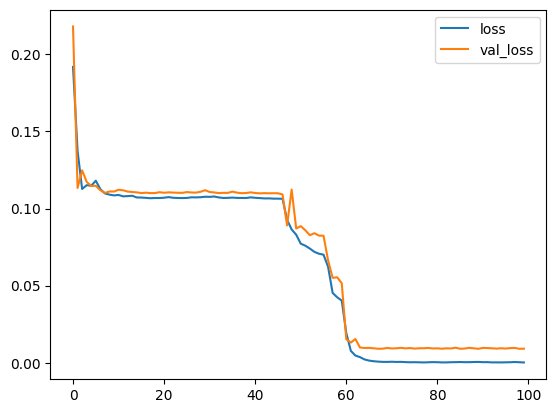

In [22]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['loss','val_loss'])
plt.show()

In [26]:
history = model.fit(x=X_train,y=y_train,batch_size=10,epochs=200,
                    validation_data=(X_test,y_test),initial_epoch=101)

Epoch 102/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 87ms/step - loss: 1.4341e-04 - val_loss: 0.0094
Epoch 103/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 88ms/step - loss: 1.9063e-04 - val_loss: 0.0092
Epoch 104/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 104ms/step - loss: 1.7017e-04 - val_loss: 0.0092
Epoch 105/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step - loss: 1.4215e-04 - val_loss: 0.0094
Epoch 106/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 86ms/step - loss: 1.4250e-04 - val_loss: 0.0092
Epoch 107/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 95ms/step - loss: 1.6614e-04 - val_loss: 0.0091
Epoch 108/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step - loss: 1.5148e-04 - val_loss: 0.0092
Epoch 109/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 86ms/step - loss: 1.8187e-04 - val_loss: 0.0093
Epoch 110/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 100ms/step - loss: 2.6168e-04 - val_loss: 0.0095
Epoch 111/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step - loss: 2.5045e-04 - val_loss: 0.0092
Epoch 112/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 84ms/step - loss: 1.6776e-04 - val

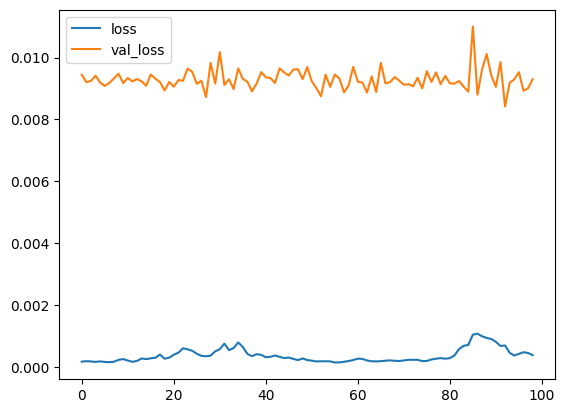

In [27]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['loss','val_loss'])
plt.show()

In [28]:
model.save('object_detection_2.h5')
model.save('object_detection_2.keras')